# Description of the project

Prepare a prototype machine learning model for Zifra. The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore. You have data with extraction and cleaning parameters at your disposal.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

I need:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

To complete the project, refer to *pandas*, *matplotlib* and *sklearn.* libraries, their documentation will help you.

### Content

##### 1. Data preparation:
* [1.1 Opening files and examining them.](#1-bullet)
* [1.2 Verify that the enrichment efficiency is calculated correctly. Calculating it on the training sample for the feature rougher.output.recovery. Finding MAE between calculation and feature value.](#2-bullet)
* [1.3 Analysis of features not available in the test set.](#3-bullet)

##### Part 2. Data analysis:
* [2.1 How does the concentration of metals (Au, Ag, Pb) change at different stages of purification.](#4-bullet)
* [2.2 Comparison of the size distribution of raw material granules on the training and test sets.](#5-bullet)
* [2.3 Study of the total concentration of all substances at different stages: in raw materials, in roughing and final concentrates.] (#6-bullet)
    
##### Part 3. Building the model:
* [3.1 Function for calculating the final sMAPE.](#7-bullet)
* [3.2 Best Model](#8-bullet)



# 1. Data preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')


In [3]:
data_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [4]:
# find out the type of the value
data_train.info()
data_test.info()
data_full.info()


# remove and replace nan
mean_values = data_train.mean()

data_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
data_train = data_train.fillna(mean_values)

data_full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
data_full = data_full.fillna(mean_values)

data_test = data_test.fillna(mean_values) ### extra

data_test_new = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')
data_test_new.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
data_test_new = data_test_new.fillna(mean_values)

# delete dates
data_train = data_train.drop('date', axis=1)
data_test = data_test.drop('date', axis=1)
data_full = data_full.drop('date', axis=1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
data_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

<a id="1-bullet"></a>
**Removed nan in target features. In the remaining columns, I replaced the value with the average and deleted the column with dates. You won't be able to train the model with it.**

In [6]:
F = data_train['rougher.input.feed_au']
C = data_train['rougher.output.concentrate_au']
T = data_train['rougher.output.tail_au']

In [7]:
data_train['recovery'] = ((C * (F - T)) / (F * (C - T)))*100
data_train = data_train.dropna().reset_index(drop=True)

In [8]:
data_train[['rougher.output.recovery','recovery']].head(10)

,rougher.output.recovery,recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


<a id="2-bullet"></a>
**values differ. Downward**

In [9]:
mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery'])

9.73512347450521e-15

On average, we are off by 0.0000000000000095 when we find the enrichment efficiency. I think this is a very minor error.

**According to the results, our found variable is not very good. Somehow the model is very bad to learn from it**

In [10]:
set(list(data_train))
set(list(data_test))
set(list(data_train)) - set(list(data_test))


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'roug

In [11]:
features = data_train[data_test.columns]

<a id="3-bullet"></a>

There are no final results in the test sample
- output — product parameters
- calculation - calculated characteristics
- **As I understand it, these signs are not there because they are needed only for training**

# 2. Data analysis

In [12]:
data_full['input'] = 100 - (data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag'] + data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol'])
data_full['rougher_output'] = 100 - (data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag']+ data_full['rougher.output.concentrate_pb']+ data_full['rougher.output.concentrate_sol'])
data_full['final_output'] = 100 -(data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_pb']+ data_full['final.output.concentrate_sol'])

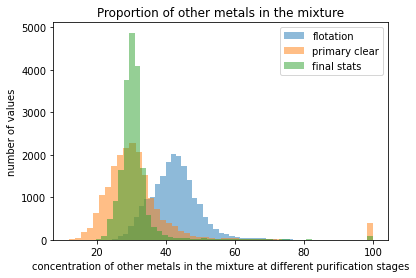

In [13]:
plt.xlabel('concentration of other metals in the mixture at different purification stages')
plt.ylabel('number of values')
plt.title('Proportion of other metals in the mixture')

x = data_full['input']
y = data_full['rougher_output']
a = data_full['final_output']


plt.hist(x, bins=50, alpha=0.5, label='flotation')
plt.hist(y, bins=50, alpha=0.5, label='primary clear')
plt.hist(a, bins=50, alpha=0.5, label='final stats')
plt.legend(loc='upper right')
plt.show()

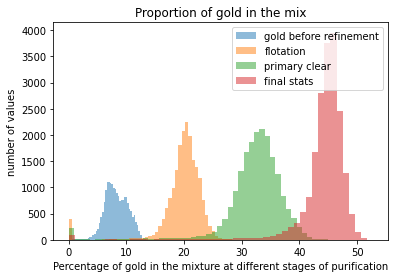

In [14]:
plt.xlabel('Percentage of gold in the mixture at different stages of purification')
plt.ylabel('number of values')
plt.title('Proportion of gold in the mix')

x = data_full['rougher.output.concentrate_au']
y = data_full['primary_cleaner.output.concentrate_au']
a = data_full['final.output.concentrate_au']
b = data_full['rougher.input.feed_au']

plt.hist(b, bins=50, alpha=0.5, label='gold before refinement')
plt.hist(x, bins=50, alpha=0.5, label='flotation')
plt.hist(y, bins=50, alpha=0.5, label='primary clear')
plt.hist(a, bins=50, alpha=0.5, label='final stats')
plt.legend(loc='upper right')
plt.show()


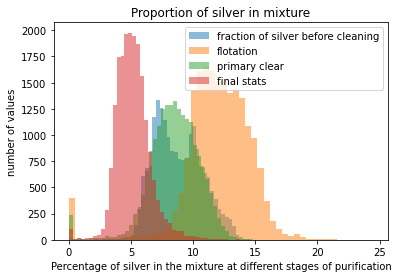

In [15]:
plt.xlabel('Percentage of silver in the mixture at different stages of purification')
plt.ylabel('number of values')
plt.title('Proportion of silver in mixture')
x = data_full['rougher.output.concentrate_ag']
y = data_full['primary_cleaner.output.concentrate_ag']
a = data_full['final.output.concentrate_ag']
b = data_full['rougher.input.feed_ag']

plt.hist(b, bins=50, alpha=0.5, label='fraction of silver before cleaning')
plt.hist(x, bins=50, alpha=0.5, label='flotation')
plt.hist(y, bins=50, alpha=0.5, label='primary clear')
plt.hist(a, bins=50, alpha=0.5, label='final stats')
plt.legend(loc='upper right')
plt.show()

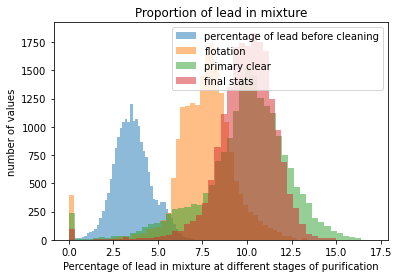

In [16]:
plt.xlabel('Percentage of lead in mixture at different stages of purification')
plt.ylabel('number of values')
plt.title('Proportion of lead in mixture')
x = data_full['rougher.output.concentrate_pb']
y = data_full['primary_cleaner.output.concentrate_pb']
a = data_full['final.output.concentrate_pb']
b = data_full['rougher.input.feed_pb']

plt.hist(b, bins=50, alpha=0.5, label='percentage of lead before cleaning')
plt.hist(x, bins=50, alpha=0.5, label='flotation')
plt.hist(y, bins=50, alpha=0.5, label='primary clear')
plt.hist(a, bins=50, alpha=0.5, label='final stats')
plt.legend(loc='upper right')
plt.show()

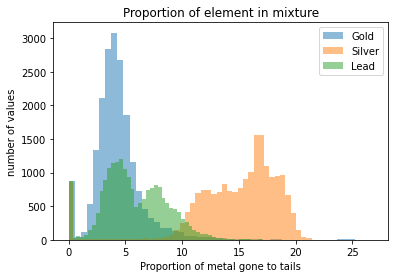

In [17]:
plt.xlabel('Proportion of metal gone to tails')
plt.ylabel('number of values')
plt.title('Proportion of element in mixture')
x = data_full['secondary_cleaner.output.tail_au']
y = data_full['secondary_cleaner.output.tail_ag']
a = data_full['secondary_cleaner.output.tail_pb']


plt.hist(x, bins=50, alpha=0.5, label='Gold')
plt.hist(y, bins=50, alpha=0.5, label='Silver')
plt.hist(a, bins=50, alpha=0.5, label='Lead')
plt.legend(loc='upper right')
plt.show()

<a id="4-bullet"></a>

**On each of the graphs, you can see that the cleaning works. And there is quite a bit of gold in the tails. Although the concentration of lead does not change much. It seems to me that there are definitely problems with its filtering. Though it may be done to weigh down the gold**

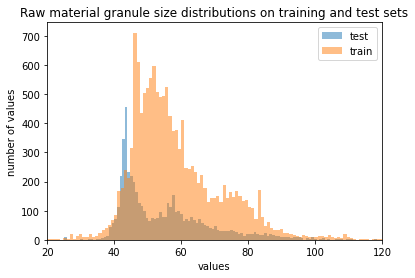

In [18]:
plt.xlabel('values')
plt.ylabel('number of values')
plt.title('Raw material granule size distributions on training and test sets')
x = data_test['rougher.input.feed_size']
y = data_train['rougher.input.feed_size']


plt.hist(x, bins=500, alpha=0.5, label='test')
plt.hist(y, bins=500, alpha=0.5, label='train')
plt.legend(loc='upper right')
plt.xlim(20, 120)
plt.show()

(20.0, 120.0)

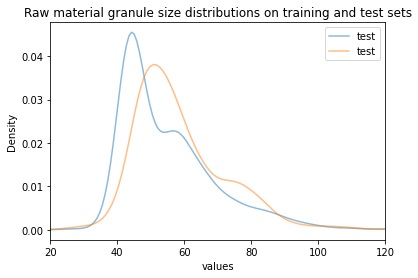

In [19]:
#matplotlib.style.use('ggplot')

plt.xlabel('values')
plt.ylabel('number of values')
plt.title('Raw material granule size distributions on training and test sets')

x = data_test['rougher.input.feed_size']
y = data_train['rougher.input.feed_size']

x.plot.kde(alpha=0.5, label='test')
y.plot.kde(alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.xlim(20, 120)

<a id="5-bullet"></a>
**The distributions differ from each other, but not much. Model score will be correct**

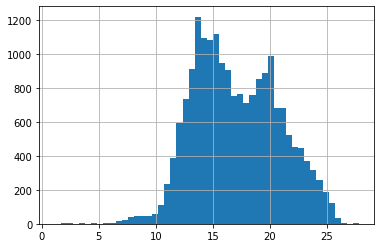

In [20]:
data_full['input_feed'] = data_full['rougher.input.feed_au'] + data_full['rougher.input.feed_ag']
+ data_full['rougher.input.feed_pb'] + data_full['rougher.input.feed_sol']
data_full = data_full.query('input_feed >= 0.1')
data_full['input_feed'].hist(bins=50) # Full table histogram
plt.show()

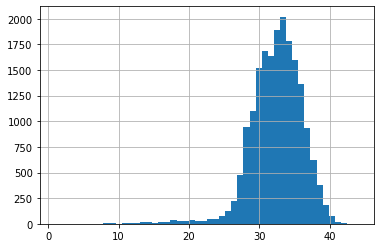

In [21]:
data_full['all_rougher'] = data_full['rougher.output.concentrate_au'] + data_full['rougher.output.concentrate_ag']
+ data_full['rougher.output.concentrate_pb'] + data_full['rougher.output.concentrate_sol']
data_full = data_full.query('all_rougher >= 0.1')
data_full['all_rougher'].hist(bins=50) # Histogram of the entire table
plt.show()

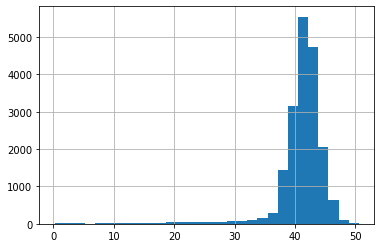

In [22]:
data_full['all_primary_cleaner'] = data_full['primary_cleaner.output.concentrate_au'] + data_full['primary_cleaner.output.concentrate_ag']
+ data_full['primary_cleaner.output.concentrate_pb'] + data_full['primary_cleaner.output.concentrate_sol']
data_full = data_full.query('all_primary_cleaner >= 0.1')
data_full['all_primary_cleaner'].hist(bins=30) # Histogram of the entire table
plt.show()

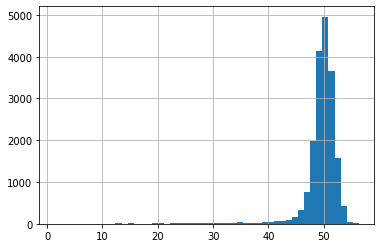

In [23]:
data_full['all_final_cleaner'] = data_full['final.output.concentrate_au'] + data_full['final.output.concentrate_ag']
+ data_full['final.output.concentrate_pb'] + data_full['final.output.concentrate_sol']
data_full = data_full.query('all_final_cleaner >= 0.1')
data_full['all_final_cleaner'].hist(bins=50) # Histogram of the entire table
plt.show()

In [24]:
def dov_int(sample):

    print("Mean:", sample.mean())

     # 95% confidence interval for average marmalade bill
     # Student's distribution scipy.stats.t
     # function for confidence interval interval()
    confidence_interval = st.t.interval(
         0.95, len(sample)-1,sample.mean(), sample.sem())

    print("95% confidence interval:", confidence_interval)

In [25]:
print('flotation', dov_int(data_full['all_rougher']))
print('primary cleaner', dov_int(data_full['all_primary_cleaner']))
print('final specs', dov_int(data_full['all_final_cleaner']))


Mean: 32.444250508311974
95% confidence interval: (32.392276951926654, 32.496224064697294)
flotation None
Mean: 41.03491695527976
95% confidence interval: (40.972395762086485, 41.09743814847304)
primary cleaner None
Mean: 49.49710747369507
95% confidence interval: (49.44267985370852, 49.551535093681615)
final specs None


<a id="6-bullet"></a>

**There are quite a few near zero emissions, but it seems to me that it would be correct to remove them. They are quite common, maybe there was just a small concentration of substances. Here null values can be removed. Since the elements we need are not there anyway.**

In [26]:
data_train = data_train[data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_ag'] 
+ data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_sol'] >= 0.1]

data_train = data_train[data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_ag'] 
+ data_train['rougher.input.feed_pb'] + data_train['rougher.input.feed_sol'] >= 0.1]

data_train = data_train[data_train['primary_cleaner.output.concentrate_au'] + data_train['primary_cleaner.output.concentrate_ag'] 
+ data_train['primary_cleaner.output.concentrate_pb'] + data_train['primary_cleaner.output.concentrate_sol'] >= 0.1]

data_train = data_train[data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_ag'] 
+ data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_sol'] >= 0.1]
features = data_train[data_test.columns]

# 3 Model

In [27]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

<a id="7-bullet"></a>
**sMAPE**

In [28]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']
features = data_train[data_test.columns]
 
def smape_final(smape_1, smape_2):
    return smape_1 * 0.25 + smape_2 * 0.75
 
model_rougher = LinearRegression()
score_rougher = (cross_val_score(model_rougher, features, target_rougher, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_rougher = score_rougher.mean()
print(final_score_rougher)
print(score_rougher)
 
model_final = LinearRegression()
score_final = (cross_val_score(model_final, features, target_final, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_final = score_final.mean()
print(final_score_final)
print(score_final)
 
print('\nfinal sMAPE on LinearRegression =', smape_final(final_score_rougher, final_score_final))

7.252333136885026
[8.79375445 7.13717429 6.07493525 5.0979531  9.1578486 ]
11.281566252428957
[13.32817869 10.24645028 10.23685971  9.29803358 13.29830901]

final sMAPE on LinearRegression = 10.274257973542975


In [29]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']


 
best_mae = 100
for depth in range(1, 6, 1): 
    model_rougher = RandomForestRegressor(n_estimators=1, max_depth=depth, random_state=12345)
    score_rougher = (cross_val_score(model_rougher, features, target_rougher, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
    final_score_rougher = score_rougher.mean()
    print(final_score_final)
    print(score_final)
    for dep in range(1, 6, 1):
        model_final = RandomForestRegressor(n_estimators=1, max_depth=dep, random_state=12345)
        score_final = (cross_val_score(model_final, features, target_final, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
        final_score_final = score_final.mean()
        print(final_score_final)
        print(score_final)

        mae = smape_final(final_score_rougher, final_score_final)
        print('MAE', mae)
        if mae < best_mae:
            best_mae = mae
            best_model_1 = model_rougher
            best_model_2 = model_final
print(best_mae, '\n', best_model_1,'\n',  best_model_2)

11.281566252428957
[13.32817869 10.24645028 10.23685971  9.29803358 13.29830901]
9.43499166775627
[ 9.59172037  8.07868754  8.93803451  9.58113505 10.98538087]
MAE 9.041244079435483
9.721930736258358
[ 9.6226955   7.8235356  11.28817066  9.19319407 10.68205785]
MAE 9.25644838081205
9.627664676132692
[ 9.7352279   8.12975813 11.26538759  8.67242411 10.33552566]
MAE 9.1857488357178
10.387215991341767
[10.91803713  9.66609934 11.51819172  8.34143154 11.49232022]
MAE 9.755412322124606
11.328018934585083
[11.22687773 14.21279644 10.16243127  9.14164699 11.89634224]
MAE 10.461014529557094
11.328018934585083
[11.22687773 14.21279644 10.16243127  9.14164699 11.89634224]
9.43499166775627
[ 9.59172037  8.07868754  8.93803451  9.58113505 10.98538087]
MAE 9.005423233265788
9.721930736258358
[ 9.6226955   7.8235356  11.28817066  9.19319407 10.68205785]
MAE 9.220627534642354
9.627664676132692
[ 9.7352279   8.12975813 11.26538759  8.67242411 10.33552566]
MAE 9.149927989548106
10.387215991341767
[10.9

In [30]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']

 
model_rougher = RandomForestRegressor(n_estimators=100, max_depth=3 , random_state=12345)
score_rougher = (cross_val_score(model_rougher, features, target_rougher, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_rougher = score_rougher.mean()
print(final_score_rougher)
print(score_rougher)
 
model_final = RandomForestRegressor(n_estimators=100, max_depth=1 , random_state=12345)
score_final = (cross_val_score(model_final, features, target_final, cv = 5, scoring = make_scorer(smape, greater_is_better=False)) * -1)
final_score_final = score_final.mean()
print(final_score_final)
print(score_final)
 
print('\nfinal sMAPE on RandomForestRegressor =', smape_final(final_score_rougher, final_score_final))

6.6315638410446995
[8.19323503 6.77401814 4.72524789 5.51454502 7.95077313]
9.499072940596584
[ 9.571602    8.06427217  8.8543359  10.02977844 10.97537619]

final sMAPE on RandomForestRegressor = 8.782195665708613


- final sMAPE on LinearRegression = 10.274257973543078
- final sMAPE on Tree = 8.930007865615474
- final sMAPE on RandomForestRegressor = 8.782195665708613
- **Best Model is Random Forest "RandomForestRegressor"**

In [31]:
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']
features = data_train[data_test.columns]

features_valid = data_test_new[data_test.columns]
target_valid_rougher = data_test_new['rougher.output.recovery']
target_valid_final = data_test_new['final.output.recovery']

model_rougher = RandomForestRegressor(n_estimators=100, max_depth=3 , random_state=12345)
model_rougher.fit(features, target_rougher)
predicted_rougher = model_rougher.predict(features_valid)

model_final = RandomForestRegressor(n_estimators=100, max_depth=1 , random_state=12345)
model_final.fit(features, target_final)
predicted_final = model_final.predict(features_valid)

mae = smape_final(smape(target_valid_rougher, predicted_rougher), smape(target_valid_final, predicted_final))

print('\nfinal sMAPE on RandomForestRegressor on Test_data =', mae)


final sMAPE on RandomForestRegressor on Test_data = 9.27014830718999


**final sMAPE on RandomForestRegressor on Test_data = 8.996984836760245**

In [32]:
# target column of the training sample
target_rougher = data_train['rougher.output.recovery']
target_final = data_train['final.output.recovery']

# vector of constant model predictions for test sample objects
predicted_rougher = pd.Series(target_rougher.median(), index=target_valid_rougher.index)
predicted_final = pd.Series(target_final.median(), index=target_valid_final.index)

# sMAPE constant model
smape_1 = smape(target_valid_rougher, predicted_rougher)
smape_2 = smape(target_valid_final, predicted_final)
print('final sMAPE on Median =', smape_final(smape_1, smape_2))

final sMAPE on Median = 9.450339967140751


***The model predicts a similar result. The difference is very small. The model is adequate, but the result is slightly better than with the median.***

<a id="8-bullet"></a>

# 4 Conclusion
**What to do with lead is not clear, its concentration almost does not drop after cleaning. It doesn't seem normal to me. There is a small error between the calculations and the value of the rougher.output.recovery feature. The distributions on the training and test samples do not differ much. There are very small values in the samples. This is due to the low concentration of substances. I removed these values. The best model is RandomForestRegressor. The model is adequate. But it seems to me that our model will not help much. Because we get a better result than when we take the median.**